<a href="https://colab.research.google.com/github/Ssurf777/physics_informed_neural_network/blob/main/Chair_PINNS_heat_diffusion20240825.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 1.1507389982712302
Epoch 10, Loss: 0.12268416393986016
Epoch 20, Loss: 0.08882390802185171
Epoch 30, Loss: 0.08782158558689818
Epoch 40, Loss: 0.08569113038487203
Epoch 50, Loss: 0.07264108222104174
Epoch 60, Loss: 0.07131488422404314
Epoch 70, Loss: 0.07405076178759296
Epoch 80, Loss: 0.0755222350496538
Epoch 90, Loss: 0.059316856747641165


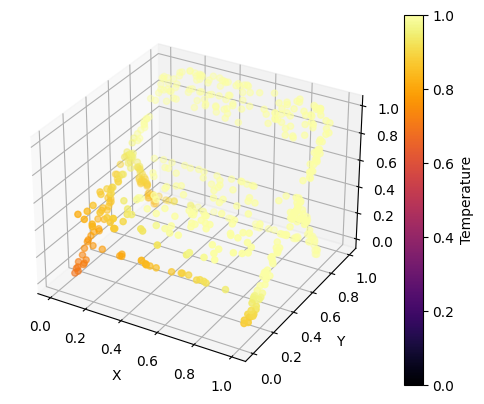

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import random

# ランダムシードの設定
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise ValueError('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

# モデル定義
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x.float()))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# 内挿域サンプリング
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * (side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t - s) * pt2[i] + (1 - t) * pt3[i]
        return (f(0), f(1), f(2))

    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = self.triangle_area(verts[faces[i][0]],
                                          verts[faces[i][1]],
                                          verts[faces[i][2]])

        sampled_faces = random.choices(faces, weights=areas, k=self.output_size)
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = self.sample_point(verts[sampled_faces[i][0]],
                                                  verts[sampled_faces[i][1]],
                                                  verts[sampled_faces[i][2]])
        return sampled_points

# 球の点群生成とクラスター化
def create_points(num_points=500, radius=1.0):
    theta = torch.rand(num_points) * 2 * torch.pi  # 0から2πの範囲でランダムに生成
    phi = torch.acos(2 * torch.rand(num_points) - 1)  # 0からπの範囲でランダムに生成

    x = radius * torch.sin(phi) * torch.cos(theta)
    y = radius * torch.sin(phi) * torch.sin(theta)
    z = radius * torch.cos(phi)

    return torch.stack([x, y, z], dim=1)

# 点群生成とクラスター化
def create_chair_points(num_points=500, radius=1.0):
    file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1,2)]
    for file_name in file_names:
        with open(file_name, 'r') as f:
            verts, faces = read_off(f)
            i,j,k = np.array(faces).T
            x,y,z = np.array(verts).T

            pointcloud = PointSampler(num_points)((verts,faces))

            # traindata
            train_x = pointcloud[:,0]
            train_y = pointcloud[:,1]
            train_z = pointcloud[:,2]
            # Convert NumPy arrays to PyTorch tensors before normalization
            train_x = torch.tensor(train_x)
            train_y = torch.tensor(train_y)
            train_z = torch.tensor(train_z)
            train_xn = (train_x - train_x.min() )/ (train_x.max() - train_x.min())
            train_yn = (train_y - train_y.min() )/ (train_y.max() - train_y.min())
            train_zn = (train_z - train_z.min() )/ (train_z.max() - train_z.min())
            return torch.stack([train_xn, train_yn, train_zn], dim=1)

# クラスタリング
def create_clusters(points, k=4):
    clusters = []
    for point in points:
        distances = torch.norm(points - point, dim=1)
        closest_neighbors_idx = torch.topk(distances, k + 1, largest=False)[1][1:]
        cluster = points[closest_neighbors_idx]
        clusters.append(cluster)
    return clusters

# ラプラシアンの計算
def compute_laplacian_with_clusters(model, clusters):
    laplacians = []
    for cluster in clusters:
        cluster.requires_grad_(True)
        T = model(cluster)

        grad_T = torch.autograd.grad(outputs=T, inputs=cluster,
                                     grad_outputs=torch.ones_like(T),
                                     create_graph=True)[0]

        laplacian = 0
        for i in range(cluster.shape[1]):
            grad2_T = torch.autograd.grad(grad_T[:, i], cluster,
                                          grad_outputs=torch.ones_like(grad_T[:, i]),
                                          create_graph=True, retain_graph=True)[0][:, i]
            laplacian += grad2_T

        laplacians.append(laplacian.mean())
    return torch.stack(laplacians)

# PINNの学習
def train_pinn_with_clusters(model, points, heat_source, epochs=100, k=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    points = points.to(device)
    heat_source = heat_source.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    clusters = create_clusters(points, k=k)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for i, point in enumerate(points):
            distance_to_source = torch.norm(point - heat_source)
            expected_temperature = 1 / (distance_to_source + 1e-8)

            laplacian = compute_laplacian_with_clusters(model, [clusters[i]])

            loss_laplacian = torch.mean(laplacian[0] ** 2)
            loss_temperature = torch.mean((model(point.unsqueeze(0)) - expected_temperature) ** 2)

            loss = loss_laplacian + loss_temperature
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss / len(points)}')

# 推論と可視化
def infer_and_visualize(model, points):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    points = points.to(device)

    with torch.no_grad():
        temperatures = model(points).cpu().numpy()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = points[:, 0].cpu().numpy()
    y = points[:, 1].cpu().numpy()
    z = points[:, 2].cpu().numpy()

    grid_x, grid_y, grid_z = np.mgrid[0:1:100j, 0:1:100j, 0:1:100j]
    grid_temp = griddata(np.vstack((x, y, z)).T, temperatures.flatten(), (grid_x, grid_y, grid_z), method='linear')

    scatter = ax.scatter(x, y, z, c=temperatures.flatten(), cmap='inferno', vmin=0, vmax=1)
    fig.colorbar(scatter, ax=ax, label='Temperature')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

# 使用例
points = create_chair_points()
model = PINN()
train_pinn_with_clusters(model, points, torch.tensor([1, 1, 1]))  # 任意の熱源を設定
infer_and_visualize(model, points)


Epoch 0, Loss: 0.7749294454277191
Epoch 10, Loss: 0.013471087558427996
Epoch 20, Loss: 0.015762800718944148
Epoch 30, Loss: 0.012511184769662193
Epoch 40, Loss: 0.016641251936664773
Epoch 50, Loss: 0.01084757713392318
Epoch 60, Loss: 0.008678321187418212
Epoch 70, Loss: 0.010874905582681364
Epoch 80, Loss: 0.0029083620347485494
Epoch 90, Loss: 0.007660874501528298


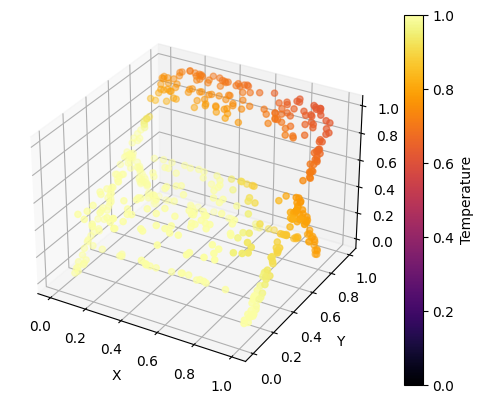

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import random

# ランダムシードの設定
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise ValueError('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

# モデル定義
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x.float()))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# 内挿域サンプリング
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * (side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t - s) * pt2[i] + (1 - t) * pt3[i]
        return (f(0), f(1), f(2))

    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = self.triangle_area(verts[faces[i][0]],
                                          verts[faces[i][1]],
                                          verts[faces[i][2]])

        sampled_faces = random.choices(faces, weights=areas, k=self.output_size)
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = self.sample_point(verts[sampled_faces[i][0]],
                                                  verts[sampled_faces[i][1]],
                                                  verts[sampled_faces[i][2]])
        return sampled_points

# 球の点群生成とクラスター化
def create_points(num_points=500, radius=1.0):
    theta = torch.rand(num_points) * 2 * torch.pi  # 0から2πの範囲でランダムに生成
    phi = torch.acos(2 * torch.rand(num_points) - 1)  # 0からπの範囲でランダムに生成

    x = radius * torch.sin(phi) * torch.cos(theta)
    y = radius * torch.sin(phi) * torch.sin(theta)
    z = radius * torch.cos(phi)

    return torch.stack([x, y, z], dim=1)

# 点群生成とクラスター化
def create_chair_points(num_points=500, radius=1.0):
    file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1,2)]
    for file_name in file_names:
        with open(file_name, 'r') as f:
            verts, faces = read_off(f)
            i,j,k = np.array(faces).T
            x,y,z = np.array(verts).T

            pointcloud = PointSampler(num_points)((verts,faces))

            # traindata
            train_x = pointcloud[:,0]
            train_y = pointcloud[:,1]
            train_z = pointcloud[:,2]
            # Convert NumPy arrays to PyTorch tensors before normalization
            train_x = torch.tensor(train_x)
            train_y = torch.tensor(train_y)
            train_z = torch.tensor(train_z)
            train_xn = (train_x - train_x.min() )/ (train_x.max() - train_x.min())
            train_yn = (train_y - train_y.min() )/ (train_y.max() - train_y.min())
            train_zn = (train_z - train_z.min() )/ (train_z.max() - train_z.min())
            return torch.stack([train_xn, train_yn, train_zn], dim=1)

# クラスタリング
def create_clusters(points, k=4):
    clusters = []
    for point in points:
        distances = torch.norm(points - point, dim=1)
        closest_neighbors_idx = torch.topk(distances, k + 1, largest=False)[1][1:]
        cluster = points[closest_neighbors_idx]
        clusters.append(cluster)
    return clusters

# ラプラシアンの計算
def compute_laplacian_with_clusters(model, clusters):
    laplacians = []
    for cluster in clusters:
        cluster.requires_grad_(True)
        T = model(cluster)

        grad_T = torch.autograd.grad(outputs=T, inputs=cluster,
                                     grad_outputs=torch.ones_like(T),
                                     create_graph=True)[0]

        laplacian = 0
        for i in range(cluster.shape[1]):
            grad2_T = torch.autograd.grad(grad_T[:, i], cluster,
                                          grad_outputs=torch.ones_like(grad_T[:, i]),
                                          create_graph=True, retain_graph=True)[0][:, i]
            laplacian += grad2_T

        laplacians.append(laplacian.mean())
    return torch.stack(laplacians)

# PINNの学習
def train_pinn_with_clusters(model, points, heat_source, epochs=100, k=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    points = points.to(device)
    heat_source = heat_source.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    clusters = create_clusters(points, k=k)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for i, point in enumerate(points):
            distance_to_source = torch.norm(point - heat_source)
            expected_temperature = 1 / (distance_to_source + 1e-8)

            laplacian = compute_laplacian_with_clusters(model, [clusters[i]])

            loss_laplacian = torch.mean(laplacian[0] ** 2)
            loss_temperature = torch.mean((model(point.unsqueeze(0)) - expected_temperature) ** 2)

            loss = loss_laplacian + loss_temperature
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss / len(points)}')

# 推論と可視化
def infer_and_visualize(model, points):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    points = points.to(device)

    with torch.no_grad():
        temperatures = model(points).cpu().numpy()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = points[:, 0].cpu().numpy()
    y = points[:, 1].cpu().numpy()
    z = points[:, 2].cpu().numpy()

    grid_x, grid_y, grid_z = np.mgrid[0:1:100j, 0:1:100j, 0:1:100j]
    grid_temp = griddata(np.vstack((x, y, z)).T, temperatures.flatten(), (grid_x, grid_y, grid_z), method='linear')

    scatter = ax.scatter(x, y, z, c=temperatures.flatten(), cmap='inferno', vmin=0, vmax=1)
    fig.colorbar(scatter, ax=ax, label='Temperature')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

# 使用例
points = create_chair_points()
model = PINN()
train_pinn_with_clusters(model, points, torch.tensor([0, 0, 0]))  # 任意の熱源を設定
infer_and_visualize(model, points)


Epoch 0, Loss: 0.013757798827427458
Epoch 10, Loss: 7.205624476247863e-05
Epoch 20, Loss: 0.00010122989880680145
Epoch 30, Loss: 3.9728690037344806e-05
Epoch 40, Loss: 3.907874358346675e-05
Epoch 50, Loss: 1.5104768337034002e-05
Epoch 60, Loss: 1.8730634413595125e-05
Epoch 70, Loss: 2.8637802266358036e-05
Epoch 80, Loss: 2.825950724808024e-05
Epoch 90, Loss: 2.7335856828178963e-05


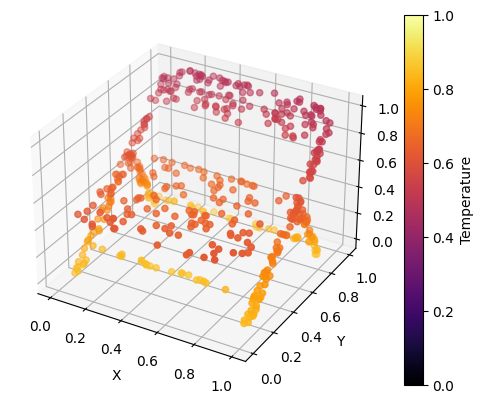

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import random

# ランダムシードの設定
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise ValueError('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

# モデル定義
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x.float()))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# 内挿域サンプリング
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * (side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t - s) * pt2[i] + (1 - t) * pt3[i]
        return (f(0), f(1), f(2))

    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = self.triangle_area(verts[faces[i][0]],
                                          verts[faces[i][1]],
                                          verts[faces[i][2]])

        sampled_faces = random.choices(faces, weights=areas, k=self.output_size)
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = self.sample_point(verts[sampled_faces[i][0]],
                                                  verts[sampled_faces[i][1]],
                                                  verts[sampled_faces[i][2]])
        return sampled_points

# 球の点群生成とクラスター化
def create_points(num_points=500, radius=1.0):
    theta = torch.rand(num_points) * 2 * torch.pi  # 0から2πの範囲でランダムに生成
    phi = torch.acos(2 * torch.rand(num_points) - 1)  # 0からπの範囲でランダムに生成

    x = radius * torch.sin(phi) * torch.cos(theta)
    y = radius * torch.sin(phi) * torch.sin(theta)
    z = radius * torch.cos(phi)

    return torch.stack([x, y, z], dim=1)

# 点群生成とクラスター化
def create_chair_points(num_points=500, radius=1.0):
    file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1,2)]
    for file_name in file_names:
        with open(file_name, 'r') as f:
            verts, faces = read_off(f)
            i,j,k = np.array(faces).T
            x,y,z = np.array(verts).T

            pointcloud = PointSampler(num_points)((verts,faces))

            # traindata
            train_x = pointcloud[:,0]
            train_y = pointcloud[:,1]
            train_z = pointcloud[:,2]
            # Convert NumPy arrays to PyTorch tensors before normalization
            train_x = torch.tensor(train_x)
            train_y = torch.tensor(train_y)
            train_z = torch.tensor(train_z)
            train_xn = (train_x - train_x.min() )/ (train_x.max() - train_x.min())
            train_yn = (train_y - train_y.min() )/ (train_y.max() - train_y.min())
            train_zn = (train_z - train_z.min() )/ (train_z.max() - train_z.min())
            return torch.stack([train_xn, train_yn, train_zn], dim=1)

# クラスタリング
def create_clusters(points, k=4):
    clusters = []
    for point in points:
        distances = torch.norm(points - point, dim=1)
        closest_neighbors_idx = torch.topk(distances, k + 1, largest=False)[1][1:]
        cluster = points[closest_neighbors_idx]
        clusters.append(cluster)
    return clusters

# ラプラシアンの計算
def compute_laplacian_with_clusters(model, clusters):
    laplacians = []
    for cluster in clusters:
        cluster.requires_grad_(True)
        T = model(cluster)

        grad_T = torch.autograd.grad(outputs=T, inputs=cluster,
                                     grad_outputs=torch.ones_like(T),
                                     create_graph=True)[0]

        laplacian = 0
        for i in range(cluster.shape[1]):
            grad2_T = torch.autograd.grad(grad_T[:, i], cluster,
                                          grad_outputs=torch.ones_like(grad_T[:, i]),
                                          create_graph=True, retain_graph=True)[0][:, i]
            laplacian += grad2_T

        laplacians.append(laplacian.mean())
    return torch.stack(laplacians)

# PINNの学習
def train_pinn_with_clusters(model, points, heat_source, epochs=100, k=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    points = points.to(device)
    heat_source = heat_source.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    clusters = create_clusters(points, k=k)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for i, point in enumerate(points):
            distance_to_source = torch.norm(point - heat_source)
            expected_temperature = 1 / (distance_to_source + 1e-8)

            laplacian = compute_laplacian_with_clusters(model, [clusters[i]])

            loss_laplacian = torch.mean(laplacian[0] ** 2)
            loss_temperature = torch.mean((model(point.unsqueeze(0)) - expected_temperature) ** 2)

            loss = loss_laplacian + loss_temperature
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss / len(points)}')

# 推論と可視化
def infer_and_visualize(model, points):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    points = points.to(device)

    with torch.no_grad():
        temperatures = model(points).cpu().numpy()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = points[:, 0].cpu().numpy()
    y = points[:, 1].cpu().numpy()
    z = points[:, 2].cpu().numpy()

    grid_x, grid_y, grid_z = np.mgrid[0:1:100j, 0:1:100j, 0:1:100j]
    grid_temp = griddata(np.vstack((x, y, z)).T, temperatures.flatten(), (grid_x, grid_y, grid_z), method='linear')

    scatter = ax.scatter(x, y, z, c=temperatures.flatten(), cmap='inferno', vmin=0, vmax=1)
    fig.colorbar(scatter, ax=ax, label='Temperature')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

# 使用例
points = create_chair_points()
model = PINN()
train_pinn_with_clusters(model, points, torch.tensor([0.5, 0.5, -1.0]))  # 任意の熱源を設定
infer_and_visualize(model, points)
